# Project Title: Web Usage Mining for Understanding User Navigation Patterns in eCommerce

Dataset url : https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store?select=2019-Oct.csv

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

from mlxtend.frequent_patterns import fpgrowth, association_rules
from scipy.sparse import csr_matrix, hstack
from collections import defaultdict

import networkx as nx
import plotly.graph_objects as go
from plotly.offline import plot

# PyMining needs to be installed first
!pip install pymining
from pymining import seqmining


# Data Loading and Cleaning

In [1]:
import pandas as pd

file_path = '/content/drive/MyDrive/2019-Oct.csv'

data = pd.read_csv(file_path, nrows=100000)

data.head()
data.info()
data.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     100000 non-null  object 
 1   event_type     100000 non-null  object 
 2   product_id     100000 non-null  int64  
 3   category_id    100000 non-null  int64  
 4   category_code  67413 non-null   object 
 5   brand          85607 non-null   object 
 6   price          100000 non-null  float64
 7   user_id        100000 non-null  int64  
 8   user_session   100000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.9+ MB


Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [2]:
data.isnull().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,32587
brand,14393
price,0
user_id,0
user_session,0


In [3]:
import pandas as pd

# Convert 'event_time' to datetime format, coercing errors to NaT (missing datetime)
data['event_time'] = pd.to_datetime(data['event_time'], errors='coerce')
data = data[data['event_time'].notna()]

data = data.dropna(subset=['product_id', 'user_id'])

if data['event_type'].isna().sum() > 0:
    most_frequent_event = data['event_type'].mode()[0]
    data['event_type'] = data['event_type'].fillna(most_frequent_event)

data.loc[:, 'category_code'] = data['category_code'].fillna('unknown_category')
data.loc[:, 'brand'] = data['brand'].fillna('unknown_brand')
data = data[(data['product_id'] != 'UNKNOWN_PRODUCT') & (data['user_id'] != 'UNKNOWN_USER')]
data = data[data['event_type'].isin(['view', 'cart', 'purchase'])]
data.drop_duplicates(subset=['event_time', 'product_id', 'user_id', 'event_type', 'category_code', 'brand'], inplace=True)

data.reset_index(drop=True, inplace=True)
#print(data.head())

# Check for missing values to confirm they were handled
print("\nMissing Values After Cleaning:")
print(data.isnull().sum())



Missing Values After Cleaning:
event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64


# Mapping of product_id to category_code

In [4]:
product_category_code_mapping = data[['product_id', 'category_code']].drop_duplicates()
product_category_code_dict = pd.Series(product_category_code_mapping.category_code.values,
                                       index=product_category_code_mapping.product_id).to_dict()
sample_mapping = {k: product_category_code_dict[k] for k in list(product_category_code_dict.keys())[:5]}
#print(sample_mapping)


# Exploring dataset

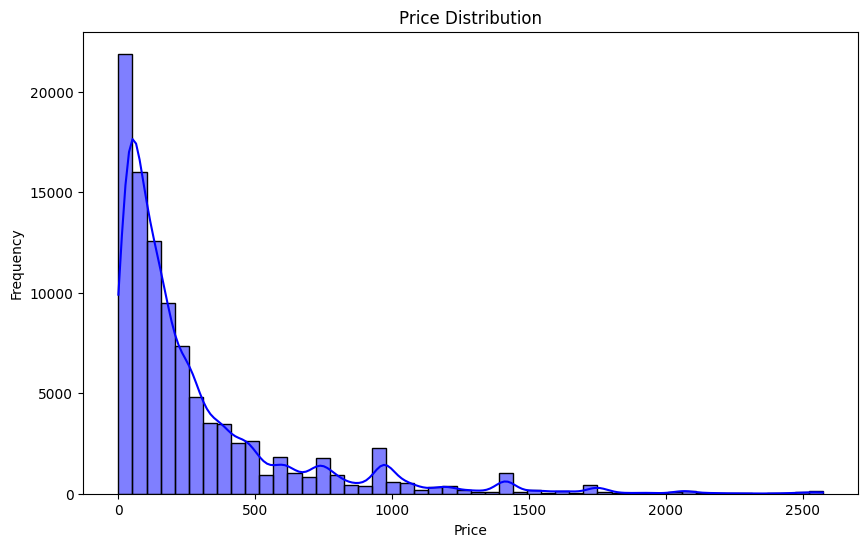

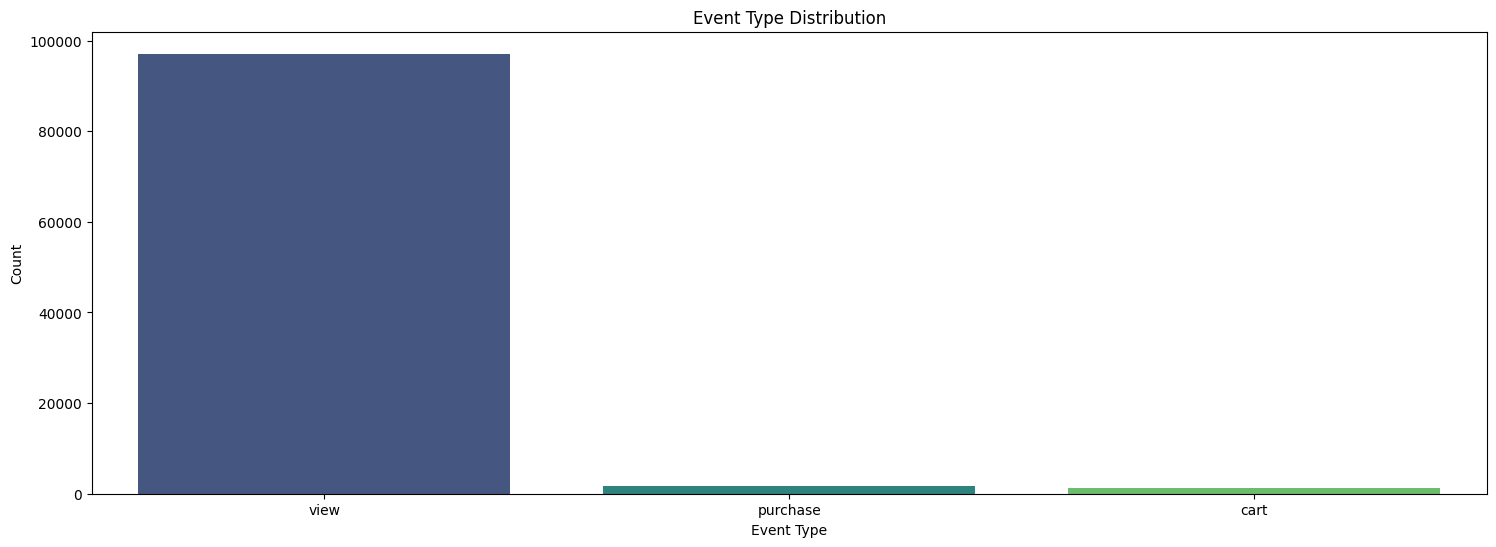

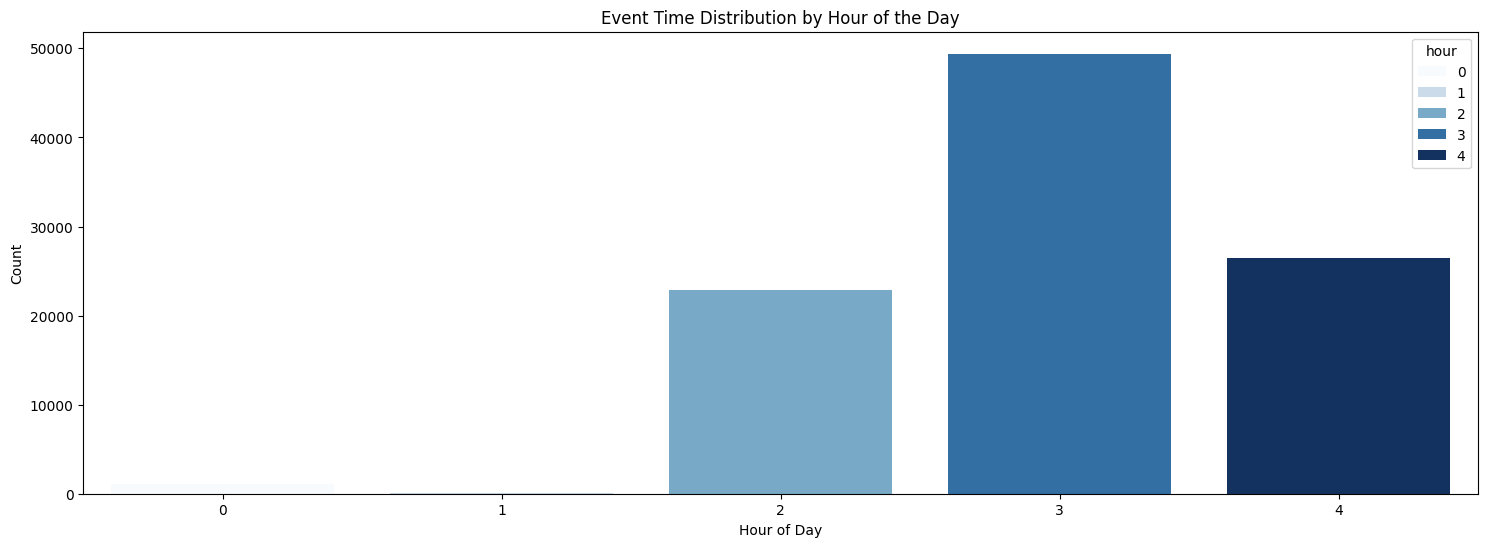

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=50, kde=True, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Event Type Distribution
plt.figure(figsize=(18, 6))
sns.countplot(data=data, x='event_type', palette='viridis',hue='event_type')
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()



# Product View/Purchase Count (Top 10 products by views)
top_products = (
    data.groupby('product_id')['event_type']
    .value_counts()
    .unstack(fill_value=0)
    .sort_values(by='view', ascending=False)
    .head(10)
)


# Event Time Distribution (optional: by hour)
# Only create 'hour' if it doesn't exist yet
if 'hour' not in data.columns:
    data['hour'] = data['event_time'].dt.hour

plt.figure(figsize=(18, 6))
sns.countplot(data=data, x='hour', palette='Blues',hue='hour')
plt.title('Event Time Distribution by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()


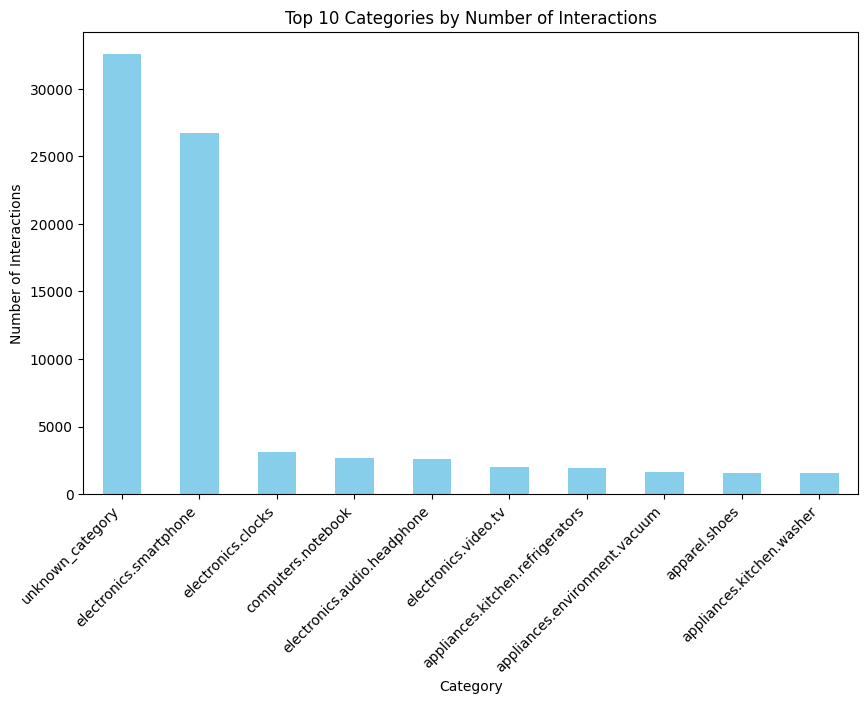

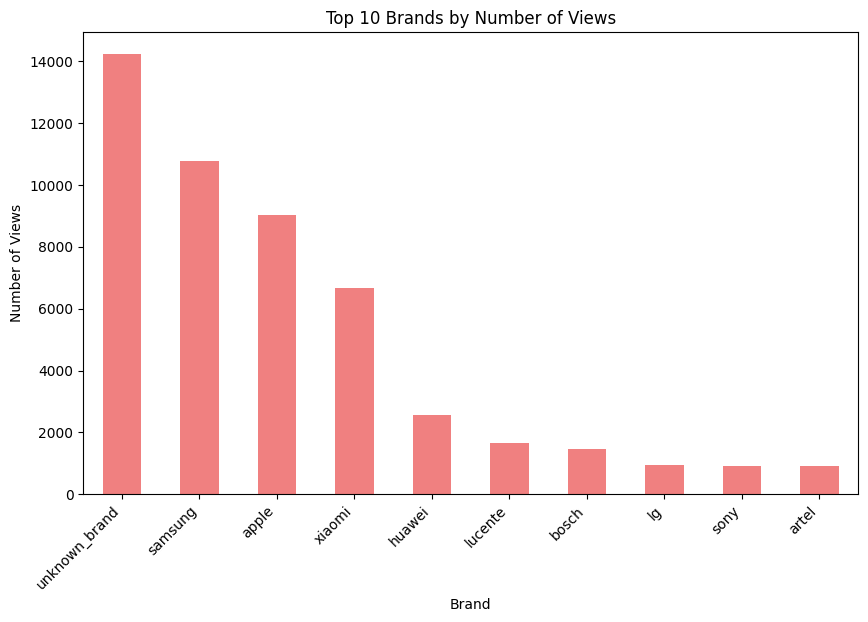

Top 10 Categories by Number of Interactions:
category_code
unknown_category                    32582
electronics.smartphone              26728
electronics.clocks                   3150
computers.notebook                   2684
electronics.audio.headphone          2607
electronics.video.tv                 1993
appliances.kitchen.refrigerators     1940
appliances.environment.vacuum        1663
apparel.shoes                        1583
appliances.kitchen.washer            1537
Name: count, dtype: int64

Top 10 Brands by Number of Views:
brand
unknown_brand    14227
samsung          10793
apple             9016
xiaomi            6665
huawei            2575
lucente           1647
bosch             1473
lg                 957
sony               907
artel              907
Name: count, dtype: int64


In [6]:
data['event_time'] = pd.to_datetime(data['event_time'], errors='coerce')
data.fillna({'product_id': 'UNKNOWN_PRODUCT', 'user_id': 'UNKNOWN_USER', 'category_code': 'UNKNOWN_CATEGORY', 'brand': 'UNKNOWN_BRAND'}, inplace=True)
data = data[data['product_id'] != 'UNKNOWN_PRODUCT']
data = data[data['event_type'].isin(['view', 'cart', 'purchase'])]
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

### 1. Top 10 Categories by Number of Interactions
data['category_code'] = data['category_code'].fillna('UNKNOWN_CATEGORY')
top_categories = data['category_code'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar', color='skyblue')
plt.title('Top 10 Categories by Number of Interactions')
plt.xlabel('Category')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45, ha='right')
plt.show()

### 2. Top 10 Brands by Number of Views
views_by_brand = data[data['event_type'] == 'view']
top_brands = views_by_brand['brand'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_brands.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Brands by Number of Views')
plt.xlabel('Brand')
plt.ylabel('Number of Views')
plt.xticks(rotation=45, ha='right')
plt.show()


print("Top 10 Categories by Number of Interactions:")
print(top_categories)

print("\nTop 10 Brands by Number of Views:")
print(top_brands)



# Clustering :  on the basis of event counts (view,cart and purchase)

           view_count  cart_count  purchase_count
user_id                                          
306441847           0           0               2
362699320           0           0               7
370076704           0           0               1
372804920           0           0               2
372944259           0           0               2


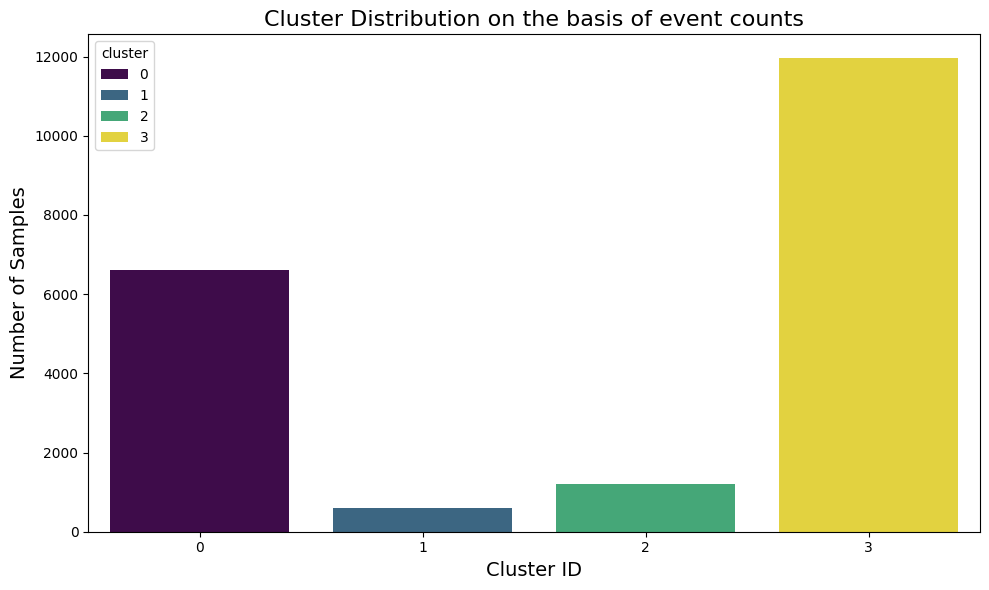

         view_count  cart_count  purchase_count
cluster                                        
0          0.015866    0.108794        6.566032
1          1.625632    1.391231        6.971332
2          0.023967    0.090909       24.809091
3          0.009111    0.000000        1.630778


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregating data by user_id and event_type
user_features = data.groupby('user_id')['event_type'].value_counts().unstack(fill_value=0)
user_features.columns = ['view_count', 'cart_count', 'purchase_count']
print(user_features.head())

# Fill missing values with the mean of each column
user_features['view_count'] = user_features['view_count'].fillna(user_features['view_count'].mean())
user_features['cart_count'] = user_features['cart_count'].fillna(user_features['cart_count'].mean())
user_features['purchase_count'] = user_features['purchase_count'].fillna(user_features['purchase_count'].mean())

# Standardize the features (scaling to bring all features to the same scale)
scaler = StandardScaler()
features_for_clustering = user_features[['view_count', 'cart_count', 'purchase_count']]  # Use event counts for clustering
scaled_features = scaler.fit_transform(features_for_clustering)

# Apply MiniBatchKMeans clustering (faster for large datasets)
minibatch_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1000)
user_features['cluster'] = minibatch_kmeans.fit_predict(scaled_features)

# Displaying the cluster distribution as a bar plot
cluster_counts = user_features['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='viridis')
plt.title('Cluster Distribution on the basis of event counts', fontsize=16)
plt.xlabel('Cluster ID', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Optionally, check basic statistics of the clusters
print(user_features.groupby('cluster')[['view_count', 'cart_count', 'purchase_count']].mean())


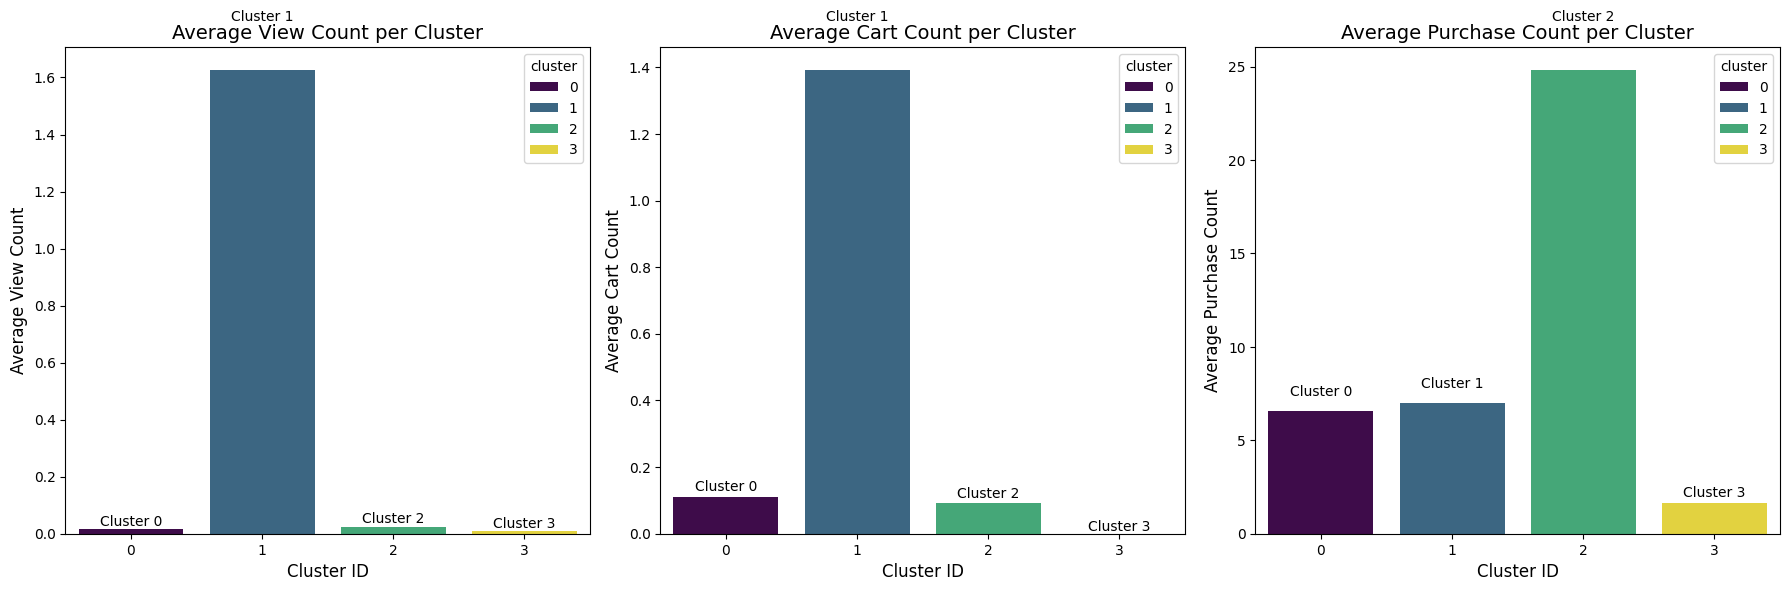

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the mean of features for each cluster
cluster_means = user_features.groupby('cluster')[['view_count', 'cart_count', 'purchase_count']].mean()

# Create subplots to visualize cluster characteristics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the average view_count for each cluster with hue assigned
sns.barplot(x=cluster_means.index, y=cluster_means['view_count'], ax=axes[0], hue=cluster_means.index, palette='viridis')
axes[0].set_title('Average View Count per Cluster', fontsize=14)
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Average View Count', fontsize=12)

# Annotating with cluster number
for i in range(len(cluster_means['view_count'])):
    axes[0].text(i, cluster_means['view_count'].iloc[i] + (cluster_means['view_count'].iloc[i] * 0.1),  # Increased offset
                 f'Cluster {i}', ha='center', fontsize=10, verticalalignment='bottom')

# Plotting the average cart_count for each cluster with hue assigned
sns.barplot(x=cluster_means.index, y=cluster_means['cart_count'], ax=axes[1], hue=cluster_means.index, palette='viridis')
axes[1].set_title('Average Cart Count per Cluster', fontsize=14)
axes[1].set_xlabel('Cluster ID', fontsize=12)
axes[1].set_ylabel('Average Cart Count', fontsize=12)

# Annotating with cluster number
for i in range(len(cluster_means['cart_count'])):
    axes[1].text(i, cluster_means['cart_count'].iloc[i] + (cluster_means['cart_count'].iloc[i] * 0.1),  # Increased offset
                 f'Cluster {i}', ha='center', fontsize=10, verticalalignment='bottom')

# Plotting the average purchase_count for each cluster with hue assigned
sns.barplot(x=cluster_means.index, y=cluster_means['purchase_count'], ax=axes[2], hue=cluster_means.index, palette='viridis')
axes[2].set_title('Average Purchase Count per Cluster', fontsize=14)
axes[2].set_xlabel('Cluster ID', fontsize=12)
axes[2].set_ylabel('Average Purchase Count', fontsize=12)

# Annotating with cluster number
for i in range(len(cluster_means['purchase_count'])):
    axes[2].text(i, cluster_means['purchase_count'].iloc[i] + (cluster_means['purchase_count'].iloc[i] * 0.1),  # Increased offset
                 f'Cluster {i}', ha='center', fontsize=10, verticalalignment='bottom')

# Show the plot with tight layout to avoid overlap
plt.tight_layout()
plt.show()


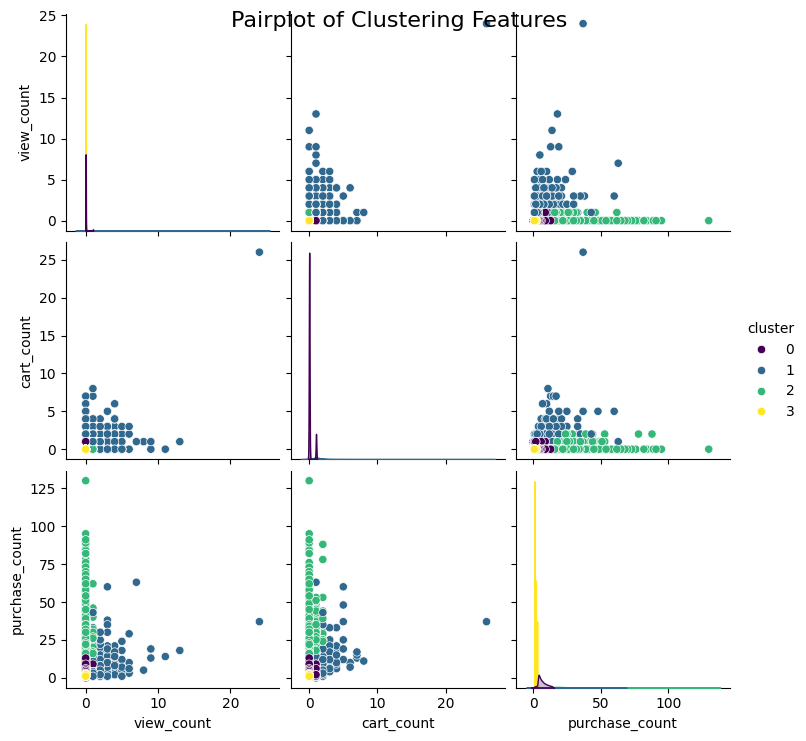

In [9]:
import seaborn as sns

# Pairplot showing relationships between features, color-coded by cluster
sns.pairplot(user_features[['view_count', 'cart_count', 'purchase_count', 'cluster']],
             hue='cluster', palette='viridis', markers='o', height=2.5)

plt.suptitle('Pairplot of Clustering Features', fontsize=16)
plt.show()


# ASSOCIATION RULE MINING

This data has very less around 5-6% cart and purchase data. So , it was difficult to get rules and had to keep min_support=0.0001

In [10]:
import warnings
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth
from scipy.sparse import csr_matrix
from collections import defaultdict

warnings.filterwarnings("ignore", category=DeprecationWarning)

product_category_code_mapping = data[['product_id', 'category_code']].drop_duplicates()

product_category_code_dict = pd.Series(product_category_code_mapping.category_code.values,
                                       index=product_category_code_mapping.product_id).to_dict()

# Extract relevant transactions (cart, purchase)
transactions = data[data['event_type'].isin(['cart', 'purchase'])]

# Group transactions by user_id to create a list of unique products per user
user_transactions = defaultdict(set)
for user, product in zip(transactions['user_id'], transactions['product_id']):
    user_transactions[user].add(product)

# Convert to DataFrame for further processing
transaction_list = [(user, list(products)) for user, products in user_transactions.items()]
transactions_per_user_df = pd.DataFrame(transaction_list, columns=['user_id', 'products'])

# Map unique products to indices for memory-efficient encoding
all_products = set(product for products in user_transactions.values() for product in products)
product_to_index = {product: idx for idx, product in enumerate(all_products)}

# Sparse matrix construction
rows, cols, data_matrix = [], [], []
for user_idx, (user, products) in enumerate(transaction_list):
    for product in products:
        rows.append(user_idx)
        cols.append(product_to_index[product])
        data_matrix.append(1)

# Create sparse matrix
sparse_matrix = csr_matrix((data_matrix, (rows, cols)), shape=(len(user_transactions), len(product_to_index)))

# Convert sparse matrix to DataFrame for FP-Growth
df_one_hot = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=product_to_index.keys())
df_one_hot.columns = [str(col) for col in df_one_hot.columns]

# Run FP-Growth with a lower min_support threshold to capture more frequent itemsets
frequent_itemsets = fpgrowth(df_one_hot, min_support=0.0001, use_colnames=True)

# Map product IDs in frequent itemsets to category codes using product_category_code_dict
frequent_itemsets['category_codes'] = frequent_itemsets['itemsets'].apply(
    lambda itemset: {product_category_code_dict.get(int(product_id), 'Unknown') for product_id in itemset}
)

# Output frequent itemsets
print("Frequent Itemsets from FP-Growth:")
print(frequent_itemsets[['itemsets', 'category_codes']])

from mlxtend.frequent_patterns import association_rules

# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1,num_itemsets=len(frequent_itemsets))

# Map product IDs in rules to category codes using product_category_code_dict
rules['antecedents_category'] = rules['antecedents'].apply(
    lambda itemset: {product_category_code_dict.get(int(product_id), 'Unknown') for product_id in itemset}
)
rules['consequents_category'] = rules['consequents'].apply(
    lambda itemset: {product_category_code_dict.get(int(product_id), 'Unknown') for product_id in itemset}
)

# Output the association rules with category codes
print("Association Rules:")
#print(rules[['antecedents_category', 'consequents_category', 'support', 'confidence', 'lift']])
rules[['antecedents_category', 'consequents_category', 'support', 'confidence', 'lift']].head(10)



Frequent Itemsets from FP-Growth:
                  itemsets                                     category_codes
0                (1004856)                           {electronics.smartphone}
1                (4804056)                      {electronics.audio.headphone}
2                (1002532)                           {electronics.smartphone}
3                (5100816)                                 {unknown_category}
4               (13800054)                        {furniture.bathroom.toilet}
...                    ...                                                ...
1425  (12706441, 12718925)                                 {unknown_category}
1426  (15200718, 15200046)                                 {unknown_category}
1427    (1005116, 3701134)  {appliances.environment.vacuum, electronics.sm...
1428    (3300488, 3300349)                                 {unknown_category}
1429    (5800860, 1003317)  {electronics.audio.subwoofer, electronics.smar...

[1430 rows x 2 columns]
Assoc

,antecedents_category,consequents_category,support,confidence,lift
0,{electronics.smartphone},{electronics.audio.headphone},0.000607,0.500000,27.466667
1,{electronics.audio.headphone},{electronics.audio.headphone},0.000607,0.333333,18.311111
2,{electronics.smartphone},{electronics.smartphone},0.001820,0.100000,2.112821
3,{electronics.smartphone},{electronics.smartphone},0.000607,0.500000,274.666667
4,{electronics.smartphone},{electronics.smartphone},0.000607,0.333333,274.666667
5,{electronics.smartphone},{electronics.smartphone},0.001214,0.117647,5.385621
6,{electronics.smartphone},{electronics.smartphone},0.000607,0.500000,13.508197
7,{electronics.smartphone},{electronics.smartphone},0.000607,0.500000,48.470588
8,{electronics.smartphone},{electronics.smartphone},0.000607,1.000000,45.777778
9,{apparel.trousers},{unknown_category},0.000607,1.000000,1648.000000


In [11]:
frequent_itemsets[['itemsets', 'category_codes']]

,itemsets,category_codes
0,(1004856),{electronics.smartphone}
1,(4804056),{electronics.audio.headphone}
2,(1002532),{electronics.smartphone}
3,(5100816),{unknown_category}
4,(13800054),{furniture.bathroom.toilet}
...,...,...
1425,"(12706441, 12718925)",{unknown_category}
1426,"(15200718, 15200046)",{unknown_category}
1427,"(1005116, 3701134)","{appliances.environment.vacuum, electronics.sm..."
1428,"(3300488, 3300349)",{unknown_category}


# TOP 20 FREQUENT ITEMSETS BASED ON FP GROWTH

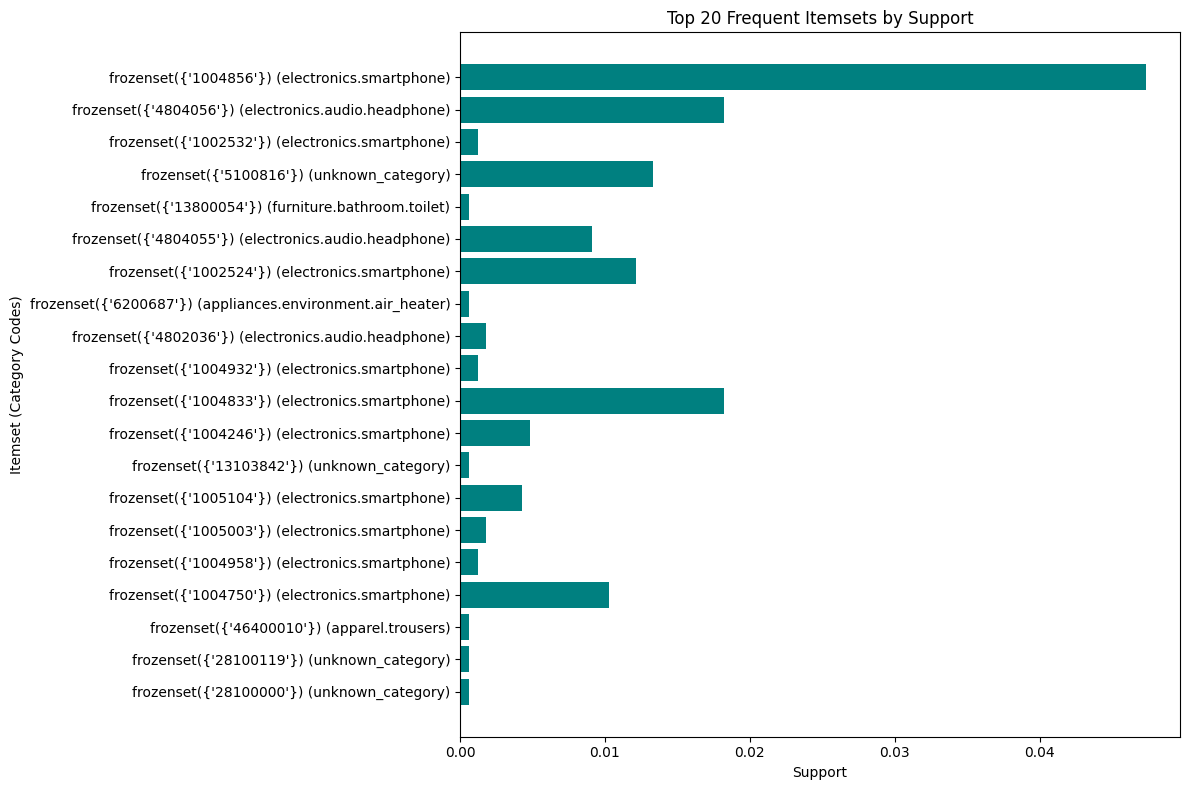

In [12]:
# Selecting top 20 frequent itemsets for visualization and making a copy
top_frequent_itemsets = frequent_itemsets.head(20).copy()

def format_category_codes(row):
    category_codes = [str(code) if pd.notna(code) else 'Unknown' for code in row['category_codes']]
    return f"{row['itemsets']} ({', '.join(category_codes)})"

# Apply formatting to create a new column for visualization
top_frequent_itemsets['itemset_category'] = top_frequent_itemsets.apply(format_category_codes, axis=1)

# Plotting the top frequent itemsets
plt.figure(figsize=(12, 8))
plt.barh(top_frequent_itemsets['itemset_category'], top_frequent_itemsets['support'], color='teal')
plt.xlabel('Support')
plt.ylabel('Itemset (Category Codes)')
plt.title('Top 20 Frequent Itemsets by Support')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# We are filtering out self-pairing rules, mapping product IDs to their respective categories, and finally, removing rules with invalid category mappings.

In [13]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2,num_itemsets=len(frequent_itemsets))

# Exclude self-pairing rules (where antecedent and consequent are the same)
rules = rules[rules['antecedents'] != rules['consequents']]

# Map product IDs in rules to category codes using product_category_code_dict BEFORE filtering
rules['antecedents_category'] = rules['antecedents'].apply(
    lambda itemset: {product_category_code_dict.get(int(product_id), 'Unknown') for product_id in itemset}
)
rules['consequents_category'] = rules['consequents'].apply(
    lambda itemset: {product_category_code_dict.get(int(product_id), 'Unknown') for product_id in itemset}
)

# Now you can filter based on 'consequents_category'
# Exclude rules with 'nan' category in the consequents
rules = rules[~rules['consequents_category'].astype(str).str.contains('nan')]



# Top recommendations based on the confidence metric

Recommendation for computers.notebook

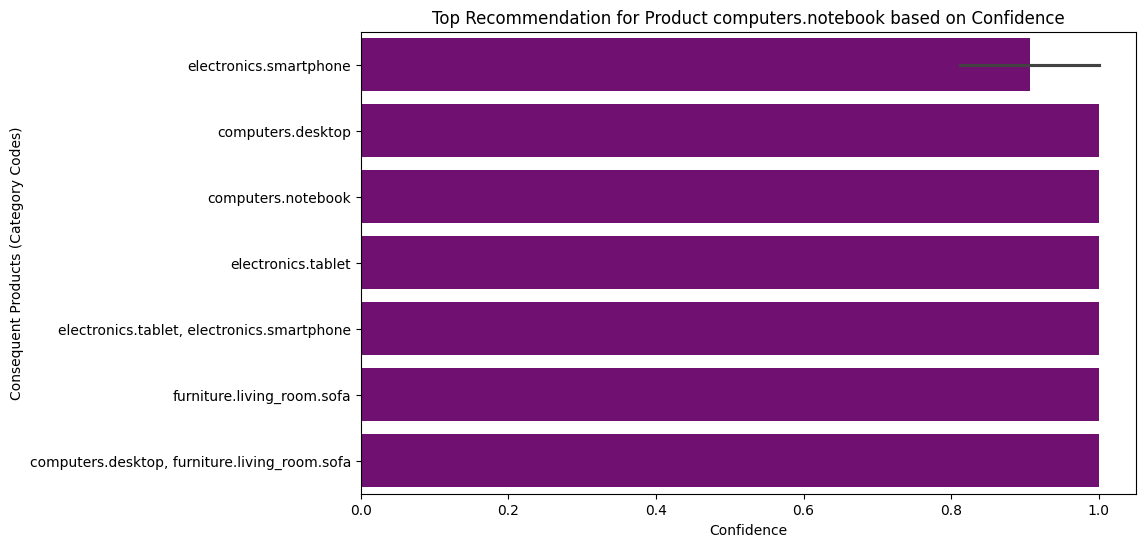

In [14]:
# Filter for the product of interest
product_of_interest = 'computers.notebook'
top_n_recommendations = rules[rules['antecedents_category'].apply(lambda x: product_of_interest in x)] # This line was the culprit


# Sort by confidence to get the top N recommendations
top_n_recommendations = top_n_recommendations.nlargest(200, 'confidence')

# Plotting the top N recommendations
plt.figure(figsize=(10, 6))
# Convert 'consequents_category' to strings for plotting
sns.barplot(
    x=top_n_recommendations['confidence'],
    y=top_n_recommendations['consequents_category'].apply(lambda x: ', '.join(x)), # Convert sets to strings
    color='purple'
)
plt.title(f'Top Recommendation for Product {product_of_interest} based on Confidence')
plt.xlabel('Confidence')
plt.ylabel('Consequent Products (Category Codes)')
plt.show()

# Strong vs Weak Rules (Ranking by Confidence and Lift)
Question: What are the strongest and weakest association rules based on confidence and lift?

Answer: By sorting the rules based on confidence and lift, we can extract the strongest and weakest association rules. The strongest rules have both high confidence (likelihood of the consequent occurring when the antecedent is purchased) and high lift (indicating that the association is stronger than random chance). The weakest rules show low confidence and lift, suggesting they are less reliable for recommendations.

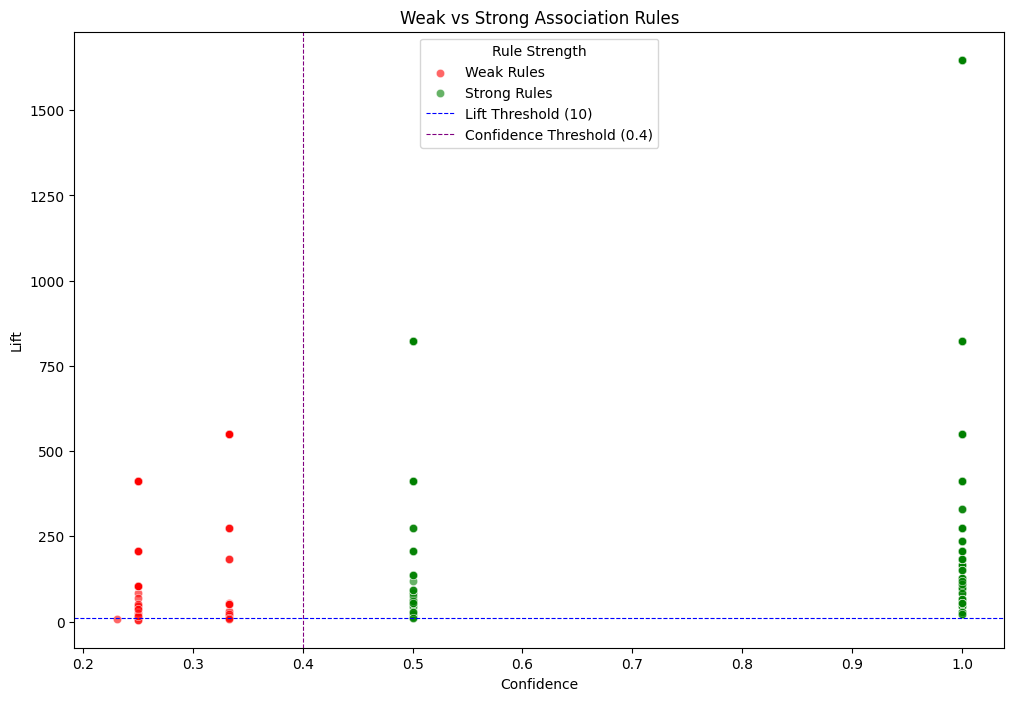

In [15]:
# -----------------------------
# Strong vs Weak Rules (Ranking by Confidence and Lift)
# -----------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Define thresholds for weak and strong rules
confidence_threshold = 0.4
lift_threshold = 10

# Classify rules into weak and strong based on confidence and lift
def classify_rule(row):
    if row['confidence'] >= confidence_threshold and row['lift'] >= lift_threshold:
        return 'strong'
    else:
        return 'weak'

rules['strength'] = rules.apply(classify_rule, axis=1)

# Plot weak and strong rules
plt.figure(figsize=(12, 8))

# Scatter plot for weak rules
weak_rules = rules[rules['strength'] == 'weak']
sns.scatterplot(data=weak_rules, x='confidence', y='lift', color='red', label='Weak Rules', alpha=0.6)

# Scatter plot for strong rules
strong_rules = rules[rules['strength'] == 'strong']
sns.scatterplot(data=strong_rules, x='confidence', y='lift', color='green', label='Strong Rules', alpha=0.6)

# Customize the plot
plt.title('Weak vs Strong Association Rules')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.axhline(lift_threshold, color='blue', linestyle='--', linewidth=0.8, label=f'Lift Threshold ({lift_threshold})')
plt.axvline(confidence_threshold, color='purple', linestyle='--', linewidth=0.8, label=f'Confidence Threshold ({confidence_threshold})')
plt.legend(title='Rule Strength')

# Show the plot
plt.show()


# Heatmap of association rules

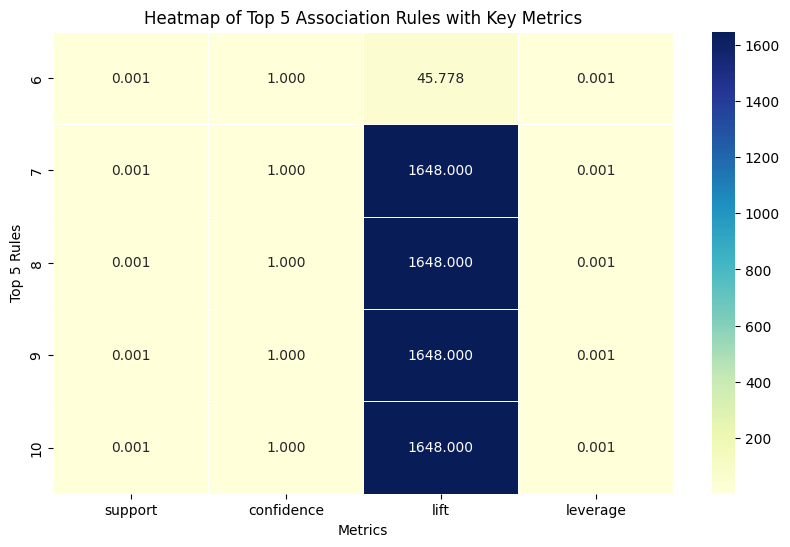

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

top_5_rules = rules.nlargest(5, 'confidence')

metrics_df = top_5_rules[['support', 'confidence', 'lift', 'leverage']]

plt.figure(figsize=(10, 6))

sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', cbar=True, fmt=".3f", linewidths=0.5)

plt.title('Heatmap of Top 5 Association Rules with Key Metrics')
plt.xlabel('Metrics')
plt.ylabel('Top 5 Rules')

plt.show()


Observations from the Heatmap of Top 5 Association Rules:
- High Confidence (1.0): All five rules exhibit perfect confidence (1.0), indicating that whenever the antecedent occurs, the consequent always follows.

- Significant Lift: Rules 7, 8, 9, and 10 have extremely high lift values (1648), suggesting a strong association between the items, implying that the occurrence of the antecedent significantly increases the likelihood of the consequent.

- Low Support (0.001): Despite high confidence and lift, all rules have very low support (0.001), meaning these item combinations occur infrequently in the dataset.

- Consistent Leverage (0.001): Leverage values are also low across all rules, indicating that the additional frequency brought by the association between the antecedent and consequent is minimal compared to their independent occurrences.

- Rule 5 Distinction:Rule 5 has a relatively lower lift (45.778) compared to the other rules, which suggests a weaker but still noteworthy association.



# Rare Itemsets (Support < 1%)
# Question: Which itemsets are rare, with support less than 1%?

Answer: This analysis identifies rare itemsets, which are those that have a very low support value (less than 1%). These rare combinations are not frequently purchased together but may still offer niche opportunities or indicate interesting but underexplored associations.



In [17]:
# -----------------------------
# Rare Itemsets (Support < 1%)
# -----------------------------
rare_items = frequent_itemsets[frequent_itemsets['support'] < 0.01]
print("Rare Itemsets (Support < 1%):")
print(rare_items[['itemsets', 'support']])



Rare Itemsets (Support < 1%):
                  itemsets   support
2                (1002532)  0.001214
4               (13800054)  0.000607
5                (4804055)  0.009102
7                (6200687)  0.000607
8                (4802036)  0.001820
...                    ...       ...
1425  (12706441, 12718925)  0.000607
1426  (15200718, 15200046)  0.000607
1427    (1005116, 3701134)  0.000607
1428    (3300488, 3300349)  0.000607
1429    (5800860, 1003317)  0.000607

[1418 rows x 2 columns]


# Market Basket Analysis Insights (Top 10 Rules with High Lift)
# Question: What are the top 10 market basket analysis rules with the highest lift?

Answer: This insight highlights the top 10 rules where the lift is the highest. A higher lift indicates that the items in the antecedent and consequent of the rule have a stronger relationship, meaning that the items are more likely to be bought together compared to random chance.

In [18]:
# -----------------------------
# Market Basket Analysis Insights (Top 10 Rules with High Lift)
# -----------------------------
product_category_mapping = data[['product_id', 'category_code']].drop_duplicates().set_index('product_id')

def get_category_codes(items):
    """Convert product_ids in a rule to their category_codes."""
    item_list = list(items)  # Convert frozenset to list
    return [product_category_mapping.loc[item]['category_code'] if item in product_category_mapping.index else 'unknown_category' for item in item_list]

# Add category codes to rules DataFrame
top_market_basket_rules = rules.sort_values(by='lift', ascending=False).head(10)
top_market_basket_rules['antecedent_categories'] = top_market_basket_rules['antecedents'].apply(get_category_codes)
top_market_basket_rules['consequent_categories'] = top_market_basket_rules['consequents'].apply(get_category_codes)

# Display the top 10 rules with product IDs, their categories, and lift
print("Top 10 Market Basket Analysis Rules with High Lift (Including Categories):")
top_market_basket_rules[['antecedents', 'consequents', 'antecedent_categories','consequent_categories', 'lift']]


Top 10 Market Basket Analysis Rules with High Lift (Including Categories):


,antecedents,consequents,antecedent_categories,consequent_categories,lift
1596,"(26201253, 2701639)","(26200210, 26500138, 2701640)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0
1951,"(2701639, 26500138)","(26201253, 26300078, 26200591, 2701640)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0
1953,"(2701639, 26300078)","(26201253, 26200591, 26500138, 2701640)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0
1954,"(26201253, 2701639)","(26300078, 26500138, 26200591, 2701640)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0
1955,"(2701639, 26200591)","(26201253, 26300078, 26500138, 2701640)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0
1956,"(26500138, 2701640)","(26201253, 2701639, 26300078, 26200591)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0
1957,"(26300078, 26500138)","(26201253, 2701639, 26200591, 2701640)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0
1958,"(26201253, 26500138)","(2701639, 26300078, 26200591, 2701640)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0
1959,"(26200591, 26500138)","(26201253, 2701639, 26300078, 2701640)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0
1960,"(26300078, 2701640)","(26201253, 2701639, 26500138, 26200591)","[unknown_category, unknown_category]","[unknown_category, unknown_category, unknown_c...",1648.0


Observation:
1. The set of products (26300078, 26500138, 26201253) is consistently linked to the purchase of product 2701639 with a lift of 1648. This suggests that customers who purchase these products together are highly likely to also purchase product 2701639.

2. All the top rules have an exceptionally high lift value of 1648, indicating that these combinations of products are purchased together much more frequently than would be expected by chance. A lift greater than 1 indicates a positive correlation, and a lift of 1648 is a very strong indication that these products are frequently bought together, highlighting strong customer preferences.

3. The patterns indicate that when customers purchase specific products, such as (26200210, 26500138, 26201253), they are also highly likely to buy related items like (2701639, 2701640).


# Network Graph of Association Rules
# Question: How can we visualize the relationships between products based on association rules?



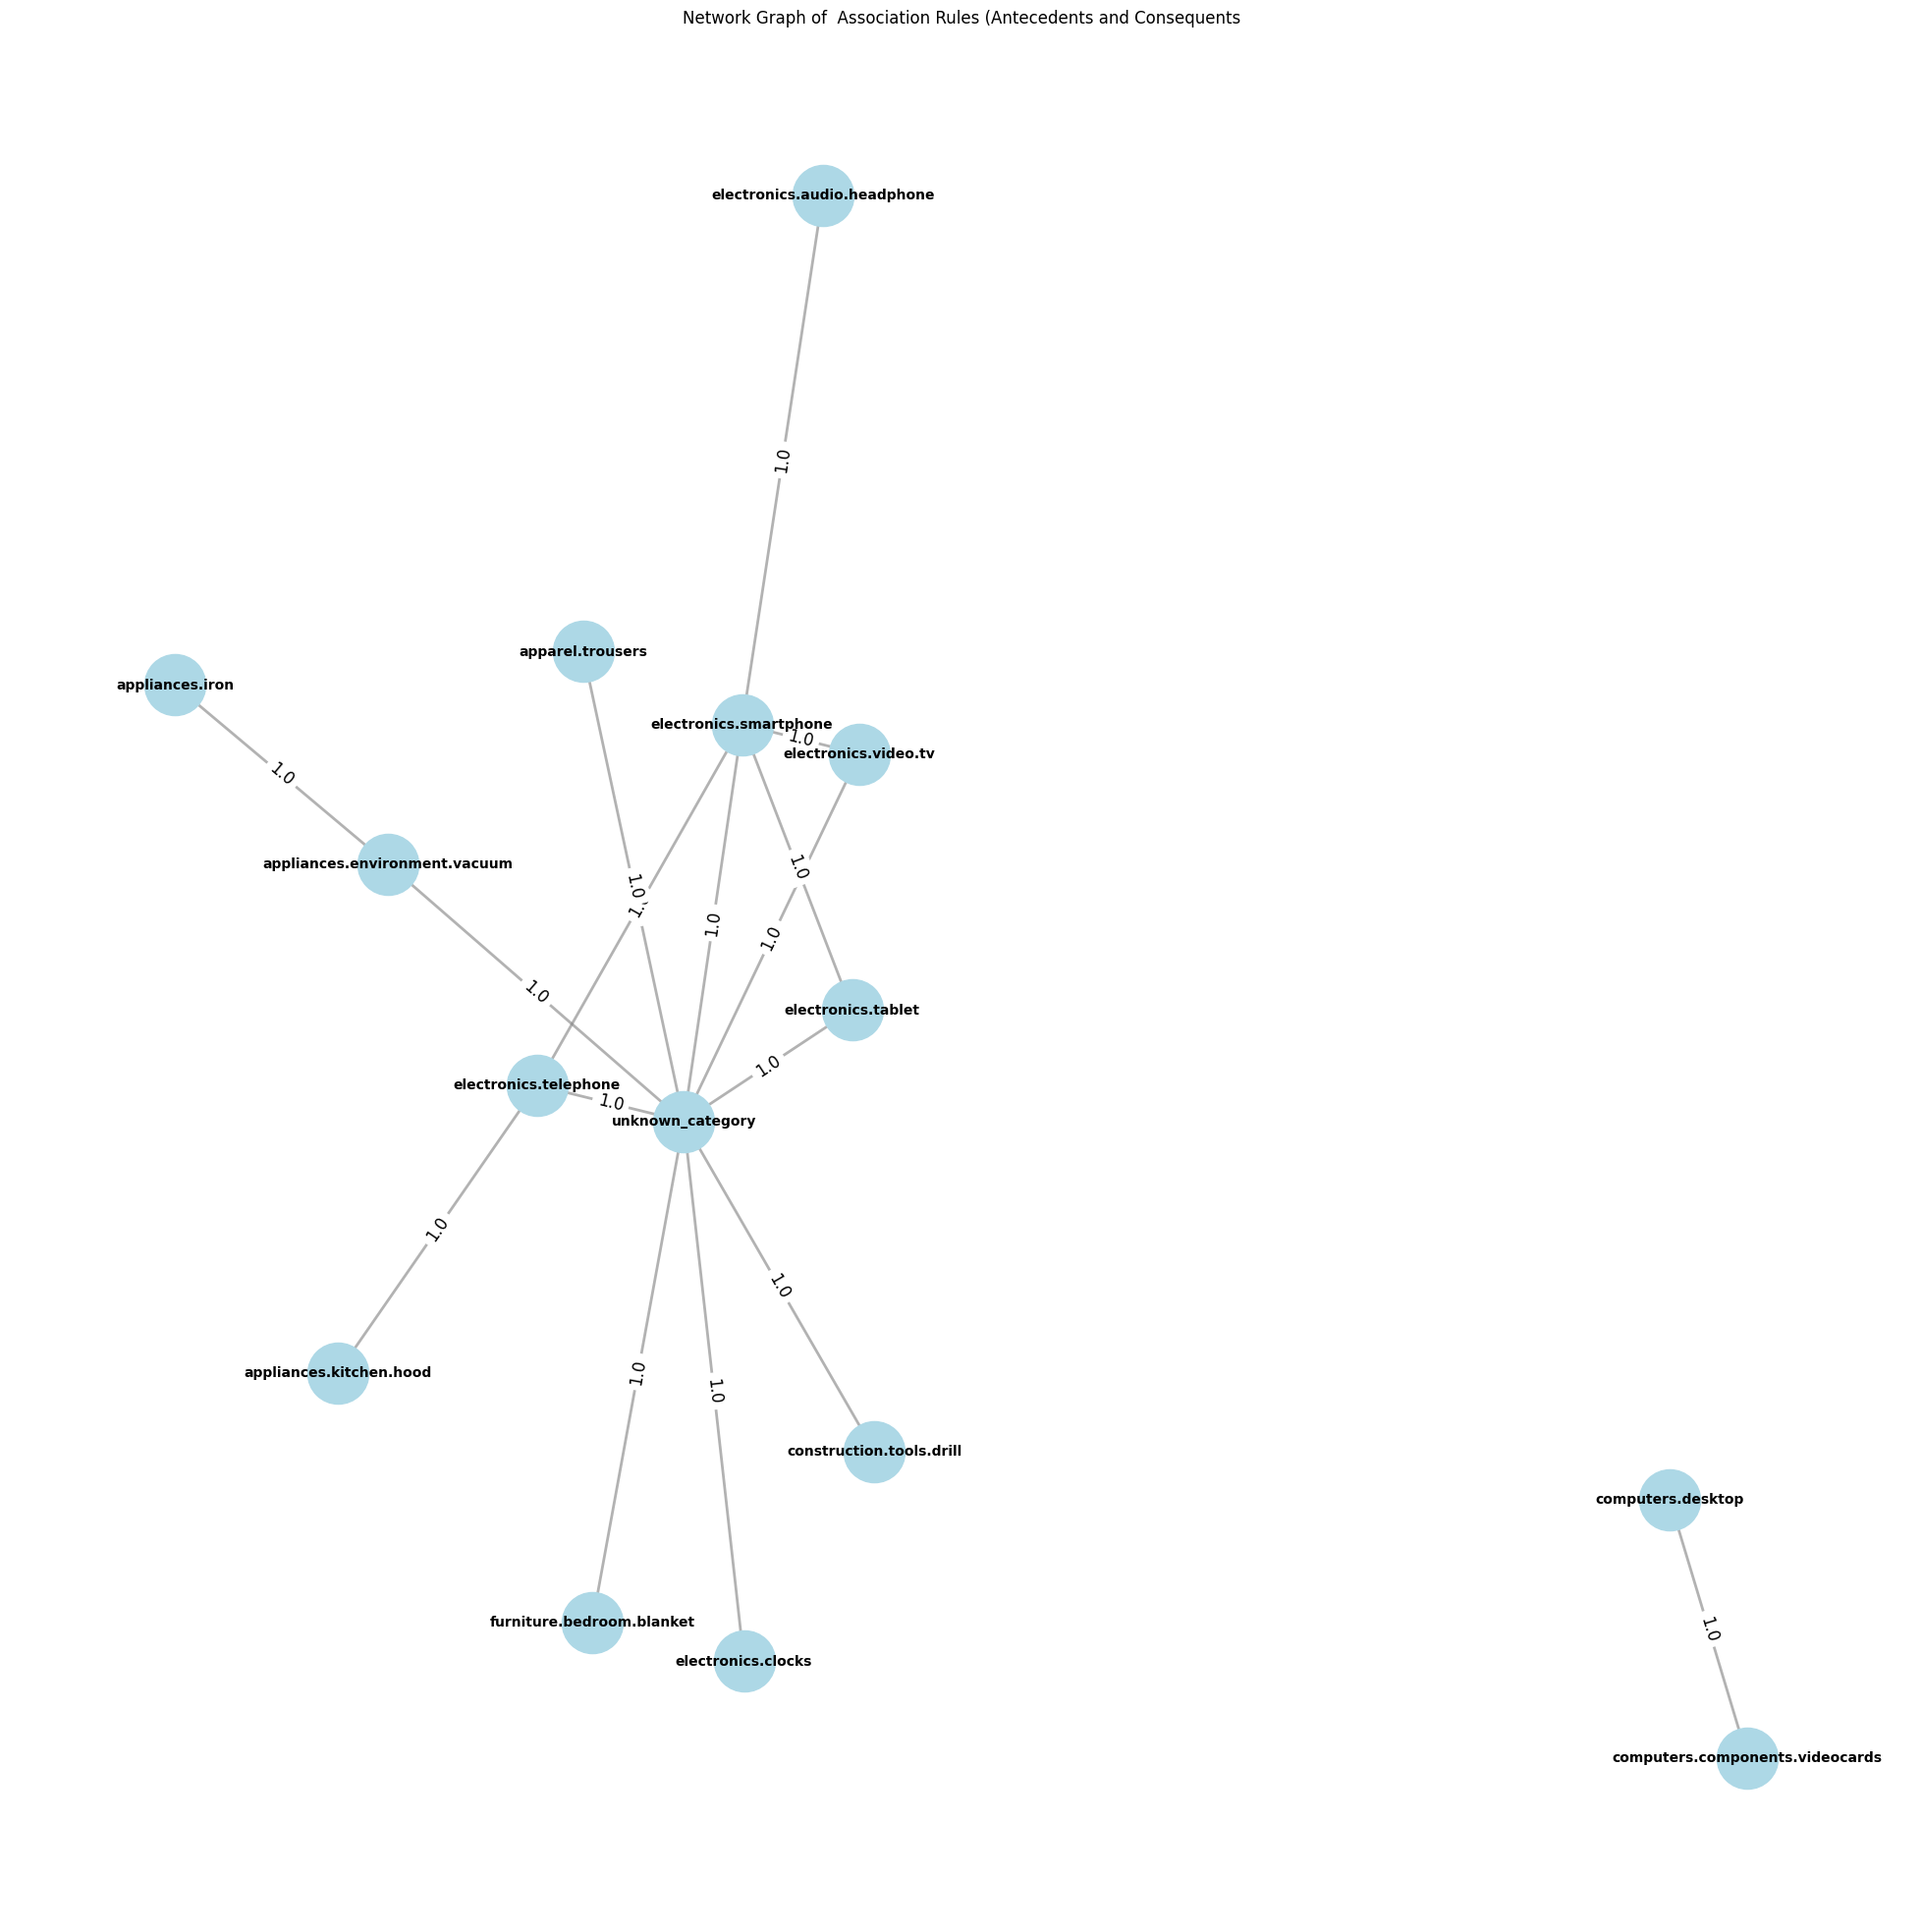

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Get the top 200 rules based on confidence
top_100_rules = rules.nlargest(200, 'confidence')
# Create an empty graph
G = nx.Graph()
# Iterate through each of the top 200 rules
for _, row in top_100_rules.iterrows():
    antecedents = row['antecedents_category']
    consequents = row['consequents_category']
    confidence = row['confidence']

    # Add nodes for antecedents and consequents if they are not already in the graph
    for antecedent in antecedents:
        if not G.has_node(antecedent):
            G.add_node(antecedent, type='antecedent')
    for consequent in consequents:
        if not G.has_node(consequent):
            G.add_node(consequent, type='consequent')

    # Add edges between antecedents and consequents, weighted by confidence
    for antecedent in antecedents:
        for consequent in consequents:
            # Skip self-loops (if antecedent is the same as consequent)
            if antecedent != consequent:
                if not G.has_edge(antecedent, consequent):
                    G.add_edge(antecedent, consequent, weight=confidence)
                else:
                    # If the edge already exists, we update the edge weight by averaging confidence
                    G[antecedent][consequent]['weight'] = (G[antecedent][consequent]['weight'] + confidence) / 2

plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G, k=0.3, iterations=50)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='gray')

nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='black')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
plt.title('Network Graph of  Association Rules (Antecedents and Consequents')
plt.axis('off')
plt.show()


# Observations from the Network Graph of Association Rules:
- Central Node ("unknown_category"): The "unknown_category" node is highly connected, suggesting that it frequently appears as a consequent or antecedent in multiple association rules. It may represent a broad or unspecified category that drives many cross-category relationships.
- Strong Electronics Cluster:Products like "electronics.smartphone," "electronics.video.tv," and "electronics.audio.headphone" are closely linked, indicating strong associations between these electronics items. This is typical behavior in eCommerce, where customers frequently purchase related electronics together.
- Isolated Product Categories:The categories "computers.desktop" and "computers.components.videocards" form a small, isolated cluster, indicating specific but limited user navigation patterns between these products, with little overlap with other categories.
- Cross-Domain Associations:There are associations between different domains, such as "appliances.kitchen.hood" and "electronics.telephone," as well as "furniture.bedroom.blanket" and "apparel.trousers." These associations could indicate cross-selling opportunities or complementary purchasing behaviors.
- Low-Degree Connections: Several nodes, such as "construction.tools.drill" and "electronics.clocks," show only one connection, indicating that these products may have niche or infrequent associations with others.


# Sequence pattern mining using PrefixSpan algorithm

In [20]:
!pip install pymining

In [21]:
import pandas as pd
from pymining import seqmining

# Filter the events to only include 'view', 'cart', and 'purchase' actions
data_filtered = data[data['event_type'].isin(['view', 'cart', 'purchase'])]

# group by user_id and user_session to create sequences of events
user_sessions = data_filtered.groupby(['user_id', 'user_session'])['event_type'].agg(list)

# Convert the user sessions to a sequence format (list of events for each user session)
sequence_data = (events for events in user_sessions)

#  Apply frequency-based sequential pattern mining using PrefixSpan algorithm
min_support = 0.01
patterns = seqmining.freq_seq_enum(sequence_data, min_support)

# Display the discovered sequential patterns
print("Discovered Frequent Sequential Patterns:")
max_patterns = 10  # Limit the number of patterns to display for clarity
for i, (pattern, support) in enumerate(patterns):
    if i >= max_patterns:
        break
    print(f"Pattern: {pattern}, Support: {support:.4f}")

# Analyze Transition Patterns for 'view' -> 'cart' and 'cart' -> 'purchase'
view_to_cart_count = 0
cart_to_purchase_count = 0

# Iterate over the user sessions and check for specific event transitions
for events in user_sessions:
    if 'view' in events and 'cart' in events:
        view_to_cart_count += 1
    if 'cart' in events and 'purchase' in events:
        cart_to_purchase_count += 1

# Display transition counts for verification
print(f"\nTransition from 'view' to 'cart' count: {view_to_cart_count}")
print(f"Transition from 'cart' to 'purchase' count: {cart_to_purchase_count}")


Discovered Frequent Sequential Patterns:
Pattern: ('purchase',), Support: 1431.0000
Pattern: ('cart',), Support: 798.0000
Pattern: ('view',), Support: 24372.0000

Transition from 'view' to 'cart' count: 798
Transition from 'cart' to 'purchase' count: 441



Observations:

- Pattern: ('purchase',), Support: 1431.0000

A frequent pattern where users end up purchasing. With a support of 1431, this indicates that there is a considerable number of instances where users make a purchase. This is a strong signal that purchasing behavior is quite common among users in your dataset.


- Pattern: ('view',), Support: 24372.0000

Viewing products is the most common action in this dataset. This high support of 24377 suggests that users are engaging with products, but not necessarily progressing to later stages like adding items to the cart or making a purchase.

- Pattern: ('cart',), Support: 798.0000

Adding items to the cart is less frequent than viewing products but still notable, with 798 occurrences. This indicates a substantial portion of users add items to their cart, but there's room for improvement in conversion.


# Transition Proportions: View -> Cart -> Purchase

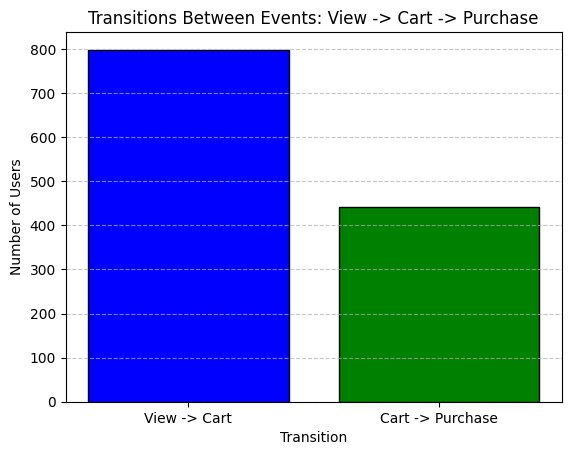

In [22]:
import matplotlib.pyplot as plt

# Transition counts
view_to_cart_count = 798
cart_to_purchase_count = 441
labels = ['View -> Cart', 'Cart -> Purchase']
counts = [view_to_cart_count, cart_to_purchase_count]

# Create a bar chart
plt.bar(labels, counts, color=['blue', 'green'])



# Customizing the chart
plt.bar(labels, counts, color=['blue', 'green'], edgecolor='black')

# Add gridlines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Transition')
plt.ylabel('Number of Users')
plt.title('Transitions Between Events: View -> Cart -> Purchase')

plt.show()


In [23]:
import plotly.graph_objects as go
from plotly.offline import plot


# Labels for the stages
labels = ['View', 'Cart', 'Purchase']

# Define transitions (source, target, and the number of users)
source = [0, 1]  # 'View' -> 'Cart', 'Cart' -> 'Purchase'
target = [1, 2]  # 'Cart', 'Purchase'
values = [798, 441]  # Transition counts

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=50,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
))

fig.update_layout(
    title="User Journey: View -> Cart -> Purchase",
    font_size=15
)

# Display the Sankey diagram using offline renderer
plot(fig, auto_open=True)


'temp-plot.html'

after running this cell, html file will be shown in the left side of notebook. We have to download it and open it chrome.

# Product Recommendation with MiniBatch KMeans

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import silhouette_score

# Load dataset efficiently
dtypes = {
    'event_time': 'str',
    'event_type': 'category',
    'product_id': 'int32',
    'category_code': 'category',
    'brand': 'category',
    'price': 'float32',
    'user_id': 'int32',
    'user_session': 'category'
}

data = pd.read_csv(
    "/content/drive/MyDrive/2019-Oct.csv",
    nrows=100000,
    dtype=dtypes,
    usecols=['user_id', 'event_type', 'category_code', 'brand', 'price', 'user_session', 'product_id']
)

data.head()

,event_type,product_id,category_code,brand,price,user_id,user_session
0,view,44600062,NaN,shiseido,35.790001,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,view,3900821,appliances.environment.water_heater,aqua,33.200001,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,view,17200506,furniture.living_room.sofa,NaN,543.099976,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,view,1307067,computers.notebook,lenovo,251.740005,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,view,1004237,electronics.smartphone,apple,1081.979980,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


Data preparation for recommendation : used combination of all features

In [25]:

# Handle missing values
data['category_code'] = data['category_code'].cat.add_categories('Unknown').fillna('Unknown')
data['brand'] = data['brand'].cat.add_categories('Unknown').fillna('Unknown')

# Event-based Aggregation
user_event_counts = data.pivot_table(index='user_id', columns='event_type', aggfunc='size', fill_value=0)
user_event_counts.columns = ['event_type_' + str(col) for col in user_event_counts.columns]

# Hierarchical Category Encoding
category_code_split = data['category_code'].str.split('>', expand=True).fillna('Unknown')
columns = [f'category_level_{i+1}' for i in range(category_code_split.shape[1])]
category_code_split.columns = columns

# Sparse one-hot encoding for hierarchical category levels
encoder = OneHotEncoder(drop='first', sparse_output=True)
category_encoded_sparse = encoder.fit_transform(category_code_split)

# Product and Brand Preferences
user_preferences = data.groupby('user_id').agg({
    'product_id': 'nunique',  # Number of unique products
    'brand': lambda x: x.mode().iloc[0],  # Most frequent brand
    'category_code': lambda x: x.mode().iloc[0]  # Most frequent category
}).reset_index()

user_preferences = pd.get_dummies(user_preferences, columns=['brand', 'category_code'])

# Price and Session Aggregation
user_price_session = data.groupby('user_id').agg({
    'price': ['mean', 'sum'],
    'user_session': 'nunique'
}).reset_index()

user_price_session.columns = ['user_id', 'price_mean', 'price_sum', 'session_count']

# Standardize price columns
scaler = StandardScaler()
user_price_session[['price_mean', 'price_sum']] = scaler.fit_transform(user_price_session[['price_mean', 'price_sum']])

# Merge all features
user_features = user_event_counts.merge(user_price_session, on='user_id')
user_features = user_features.merge(user_preferences, on='user_id')

# Handle sparse matrix size mismatch by merging on user_id in categorical features
category_encoded_df = pd.DataFrame.sparse.from_spmatrix(category_encoded_sparse)
category_encoded_df['user_id'] = data['user_id'].reset_index(drop=True)
category_grouped = category_encoded_df.groupby('user_id').sum().reset_index()

# Merge dense features with sparse ones on user_id
final_features = user_features.merge(category_grouped, on='user_id')

# Convert to sparse matrix for dimensionality reduction
user_features_sparse = csr_matrix(final_features.drop(columns=['user_id']).values)

# Dimensionality Reduction using Truncated SVD
pca = TruncatedSVD(n_components=50)
reduced_features = pca.fit_transform(user_features_sparse)
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")



<ipython-input-25-1bc88a61ee38>:6: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



Explained variance ratio: 0.97


# Mini Batch K means for recommendation

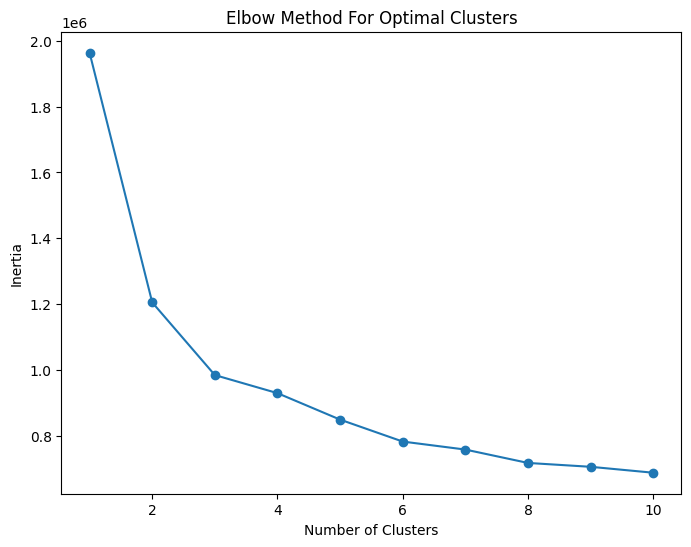

In [26]:
import matplotlib.pyplot as plt

def elbow_method(X, max_clusters=10):
    inertia = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method For Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

elbow_method(reduced_features)


In [27]:
# Clustering with MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1000)
final_features['cluster'] = minibatch_kmeans.fit_predict(reduced_features)

# Analyze Results
print(final_features[['user_id', 'cluster']].head())




     user_id  cluster
0  306441847        0
1  362699320        3
2  370076704        0
3  372804920        0
4  372944259        0


In [28]:
# Filter users belonging to cluster 4
cluster_4_users = final_features[final_features['cluster'] == 3]

# Display the user_id and cluster columns for cluster 4
print(cluster_4_users[['user_id', 'cluster']])


         user_id  cluster
1      362699320        3
8      414175028        3
50     478756812        3
52     479233261        3
56     482136003        3
...          ...      ...
20303  555482525        3
20322  555482717        3
20324  555482748        3
20362  555483213        3
20363  555483214        3

[3466 rows x 2 columns]


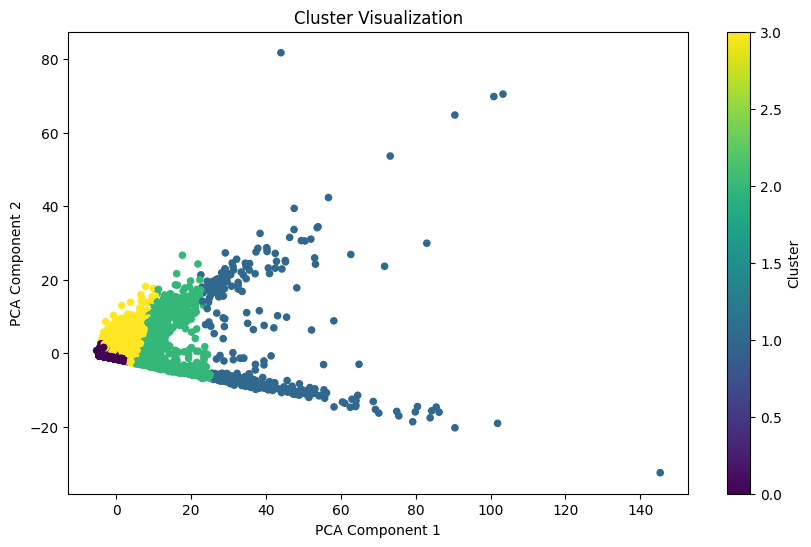

In [29]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(reduced_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], c=final_features['cluster'], cmap='viridis', marker='o', s=20)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [30]:
cluster_summary = final_features.groupby('cluster').mean()
cluster_summary

,user_id,event_type_cart,event_type_purchase,event_type_view,price_mean,price_sum,session_count,product_id,brand_a-case,brand_a-derma,...,113,114,115,116,117,118,119,120,121,122
cluster,,,,,,,,,,,,,,,,,,,,,
0,5.330139e+08,0.017611,0.044202,2.239524,-0.095062,-0.323231,1.095364,1.726298,0.000209,0.0,...,0.007796,0.001183,0.006126,0.001879,0.008144,0,0.000209,0.000348,0.002645,0.000487
1,5.298413e+08,0.176623,0.290909,37.548052,-0.190151,3.034707,2.023377,22.007792,0.000000,0.0,...,0.002597,0.158442,0.044156,0.002597,0.098701,0,0,0,0.005195,0
2,5.301691e+08,0.094139,0.131057,14.592986,-0.202607,0.846012,1.552838,9.422243,0.000000,0.0,...,0.010614,0.025842,0.027688,0.004615,0.066451,0.000923,0.000923,0.000461,0.004153,0.005999
3,5.324053e+08,0.199077,0.180035,5.446624,0.541813,0.473705,1.299192,3.527986,0.000000,0.0,...,0.004328,0.002597,0.008656,0,0.00981,0.000289,0.00202,0,0.004905,0.003174


# Silhouette Score to know how well clusters are (range : -1 to +1)


In [32]:
# Silhouette Score to evaluate clusters
sample_size = min(1000000, reduced_features.shape[0])
sampled_features = reduced_features[:sample_size]
sampled_labels = final_features['cluster'].iloc[:sample_size]

score = silhouette_score(sampled_features, sampled_labels)
print(f'Silhouette Score: {score:.3f}')


Silhouette Score: 0.364


# Most popular products in each cluster (by frequency)

In [33]:
# Merge user cluster information with the original data
data_with_cluster = data.merge(final_features[['user_id', 'cluster']], on='user_id')

# Find the most popular products in each cluster (by frequency)
product_cluster_popularity = data_with_cluster.groupby(['cluster', 'product_id']).size().reset_index(name='product_count')

# For each cluster, get top N popular products (e.g., top 5 products)
top_n = 5
top_products_per_cluster = product_cluster_popularity.groupby('cluster').apply(
    lambda x: x.nlargest(top_n, 'product_count')).reset_index(drop=True)

# Display the top products per cluster
print(top_products_per_cluster[['cluster', 'product_id', 'product_count']])




    cluster  product_id  product_count
0         0     5100816            308
1         0     4804056            280
2         0     1004856            275
3         0     1005115            223
4         0     4804295            214
5         1     1002544            103
6         1     1004833             58
7         1     1004856             57
8         1     1004870             57
9         1     1004777             46
10        2     1004856            197
11        2     1004767            148
12        2     1005115            121
13        2     1004870            114
14        2     5100816             98
15        3     1004856            601
16        3     1005115            579
17        3     1004767            548
18        3     1005105            400
19        3     1004870            325


# Recommendation

In [40]:
import numpy as np

def recommend_products(user_id, final_features, data_with_cluster, top_products_per_cluster):
    # Check if the user exists in the final_features DataFrame
    if user_id not in final_features['user_id'].values:
        print(f"User {user_id} not found in the cluster data.")
        return None  # Or handle the case appropriately

    # Find the user's cluster
    user_cluster_data = final_features.loc[final_features['user_id'] == user_id, 'cluster']
    user_cluster = user_cluster_data.iloc[0]  # Correctly access the user's cluster

    # Get the top N products for the user's cluster
    recommended_products = top_products_per_cluster[top_products_per_cluster['cluster'] == user_cluster]

    # Merge with original data to get brand and category information
    recommended_products = recommended_products.merge(data_with_cluster[['product_id', 'brand', 'category_code']], on='product_id', how='left').drop_duplicates()

    return recommended_products[['product_id', 'brand', 'category_code']]




# Testing recommendation for existing user

In [38]:
# Testing with user

user_id = 512365063

# Step 1: Recommend products for the user
recommended_products = recommend_products(user_id, final_features, data_with_cluster, top_products_per_cluster)

# Step 2: If recommended products exist, evaluate the recommendation
if recommended_products is not None:
    print(f" Recommended Products for User : {user_id}")
    print(recommended_products)
    print("\n")
    print("********************************************************************")
    print("\n")
else:
    print(f"No recommendations found for User {user_id}.")


 Recommended Products for User : 512365063
      product_id    brand           category_code
0        1002544    apple  electronics.smartphone
479      1004833  samsung  electronics.smartphone
1004     1004856  samsung  electronics.smartphone
2134     1004870  samsung  electronics.smartphone
2755     1004777   xiaomi  electronics.smartphone


********************************************************************




# USER PAST INTERACTION - BRAND,PRODUCT_ID AND category_code

In [39]:
# Fetch the user's past interactions
user_past_interactions = data[data['user_id'] == 512365063]
print(f" Past interaction of User : {user_id}")
print(user_past_interactions[['product_id', 'brand', 'category_code']])


 Past interaction of User : 512365063
       product_id    brand                category_code
67615     1004833  samsung       electronics.smartphone
67763     1004833  samsung       electronics.smartphone
68119     1004750  samsung       electronics.smartphone
76532     1004836  samsung       electronics.smartphone
76692     1004767  samsung       electronics.smartphone
77329     1004767  samsung       electronics.smartphone
77559     1004870  samsung       electronics.smartphone
77987     1004446  samsung       electronics.smartphone
78260     1004856  samsung       electronics.smartphone
78397     1004856  samsung       electronics.smartphone
78532     1004857  samsung       electronics.smartphone
78695     1004857  samsung       electronics.smartphone
78991     8800048    nokia        electronics.telephone
79066     8800048    nokia        electronics.telephone
79340     8800048    nokia        electronics.telephone
79441     8800045    nokia        electronics.telephone
79842     